# Lab 1: Learned Index Structure

In this lab, we will implement a 2-stage recursive model index (RMI) as a replacement for conventional B-tree index structures.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.10.0


In [2]:
def plot_histogram(x):
    plt.figure()
    plt.title('Data distribution')
    plt.xlabel('Key')
    plt.ylabel('Occurence')
    plt.hist(x, bins=20)
    plt.show()

In [3]:
def generate_lognormal_data(mean=0.0, sigma=2.0, size=250000):
    x = np.random.lognormal(mean=mean, sigma=sigma, size=size)
    scale = 2000000 / np.amax(x)
    x = x * scale
    x = x.astype(np.int64)
    x = np.unique(x)
    n = len(x)
    print('Lognormal distribution: {} unique data points generated.'.format(n))
    return n, x

In [4]:
def generate_positive_normal_data(loc=0.0, scale=1.0, size=250000):
    x = np.random.normal(loc=loc, scale=scale, size=size)
    x = np.clip(x, 0, None)
    scale = 1000000 / np.amax(x)
    x = x * scale
    x = x.astype(np.int64)
    x = np.unique(x)
    n = len(x)
    print('Normal distribution: {} unique data points generated.'.format(n))
    return n, x

In [5]:
def obtain_labels(x):
    y = np.argsort(x)
    y = np.argsort(y)
    return y

In [6]:
def evalute_min_max_error(golden, pred):
    error = pred - golden
    print('min error = {}'.format(np.min(error)))
    print('max error = {}'.format(np.max(error)))

## Generate data points

Call `generate_log_normal_data` or `generate_positive_normal_data` to generate synthetic data points.

Call `generate_real_data` to generate real-world data points.

The data points are stored in an 1-D integer array `x` of size `n`, with each data point representing a key.

The data distribution of `x` is shown in the following histogram.

Lognormal distribution: 21673 unique data points generated.


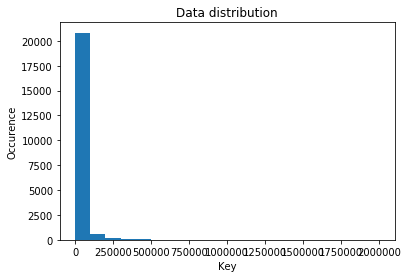

In [7]:
n, x = generate_lognormal_data()
plot_histogram(x)

## Prepare training pairs

The label of each data point is essentially the position of the data point.

In [8]:
y = obtain_labels(x)
x = np.expand_dims(x, 1)
print(x.shape)

(21673, 1)


## Build and train the first-stage model

In [9]:
model = keras.Sequential([
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='mean_squared_error',
              metrics=['accuracy'])
history = model.fit(x, y, epochs=10, batch_size=1000)

Epoch 1/10
21673/21673 [==============================] - 1s 54us/step - loss: 126718570.2701 - acc: 4.6140e-05
Epoch 2/10
21673/21673 [==============================] - 0s 2us/step - loss: 106035375.4448 - acc: 4.6140e-05
Epoch 3/10
21673/21673 [==============================] - 0s 2us/step - loss: 107355861.5771 - acc: 9.2281e-05
Epoch 4/10
21673/21673 [==============================] - 0s 2us/step - loss: 104430773.4652 - acc: 9.2281e-05
Epoch 5/10
21673/21673 [==============================] - 0s 2us/step - loss: 105790884.2283 - acc: 9.2281e-05
Epoch 6/10
21673/21673 [==============================] - 0s 2us/step - loss: 103525686.6187 - acc: 4.6140e-05
Epoch 7/10
21673/21673 [==============================] - 0s 2us/step - loss: 104654640.2344 - acc: 4.6140e-05
Epoch 8/10
21673/21673 [==============================] - 0s 2us/step - loss: 104159260.0212 - acc: 4.6140e-05
Epoch 9/10
21673/21673 [==============================] - 0s 2us/step - loss: 105296461.2873 - acc: 9.2281e-05


## Display the training process

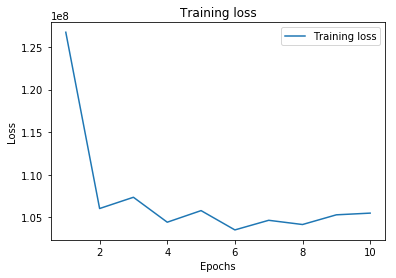

In [10]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Make prediction with the first-stage model

In [11]:
pred_first = model.predict(x)
pred_first = pred_first.flatten().astype(np.int64)
print(pred_first.shape)

(21673,)


## Evaluate the intermediate results

min error = -14146
max error = 198784


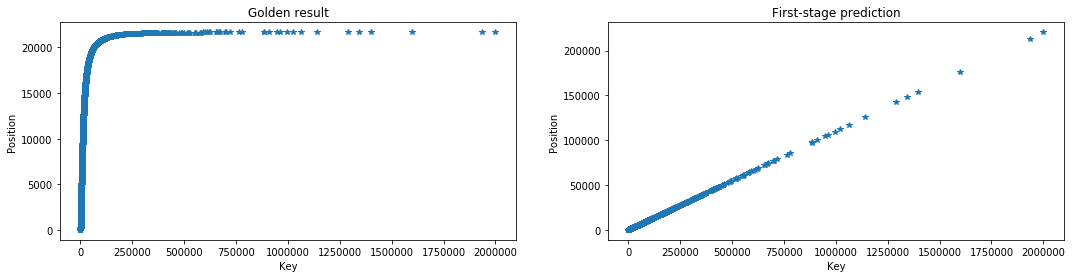

In [12]:
evalute_min_max_error(y, pred_first)
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
axes[0].set_title('Golden result')
axes[0].set_xlabel('Key')
axes[0].set_ylabel('Position')
axes[0].plot(x, y, linestyle='None', marker='*')
axes[1].set_title('First-stage prediction')
axes[1].set_xlabel('Key')
axes[1].set_ylabel('Position')
axes[1].plot(x, pred_first, linestyle='None', marker='*')
plt.show()

## Distribute data points into buckets

In [13]:
n_second_stage_model = 10
sel_model = pred_first.astype(np.float64) / n * n_second_stage_model
sel_model = sel_model.astype(np.int64)
sel_model = np.clip(sel_model, 0, n_second_stage_model - 1)
print(sel_model.shape)
x_bucket = []
y_bucket = []
for m in range(n_second_stage_model):
    x_bucket.append(x[np.where(sel_model == m)])
    y_bucket.append(y[np.where(sel_model == m)])
print(map(len, x_bucket))

(21673,)
[14715, 3755, 1308, 670, 338, 195, 162, 112, 91, 327]


## Train the second-stage models

In [14]:
wts = []
bss = []
for m in range(n_second_stage_model):
    wt, bs = (0, 0)
    if len(x_bucket[m] != 0):
        wt, bs = np.polyfit(x_bucket[m].flatten(), y_bucket[m], 1)
        print(wt, bs)
    wts.append(wt)
    bss.append(bs)

(0.7963576653000839, 883.7382303078655)
(0.19447080187826546, 11229.219357774282)
(0.06662543841545983, 15946.776378502602)
(0.03415860798470291, 17794.62253524566)
(0.01688171402417957, 19140.689571908348)
(0.00954381231625068, 19855.236542303155)
(0.008807790840778706, 19947.53269612565)
(0.005565662573015904, 20378.975367781914)
(0.004869195732140483, 20488.42086199685)
(0.00027914964725657995, 21413.24089598534)


## Show the data points (with their positions) in each bucket

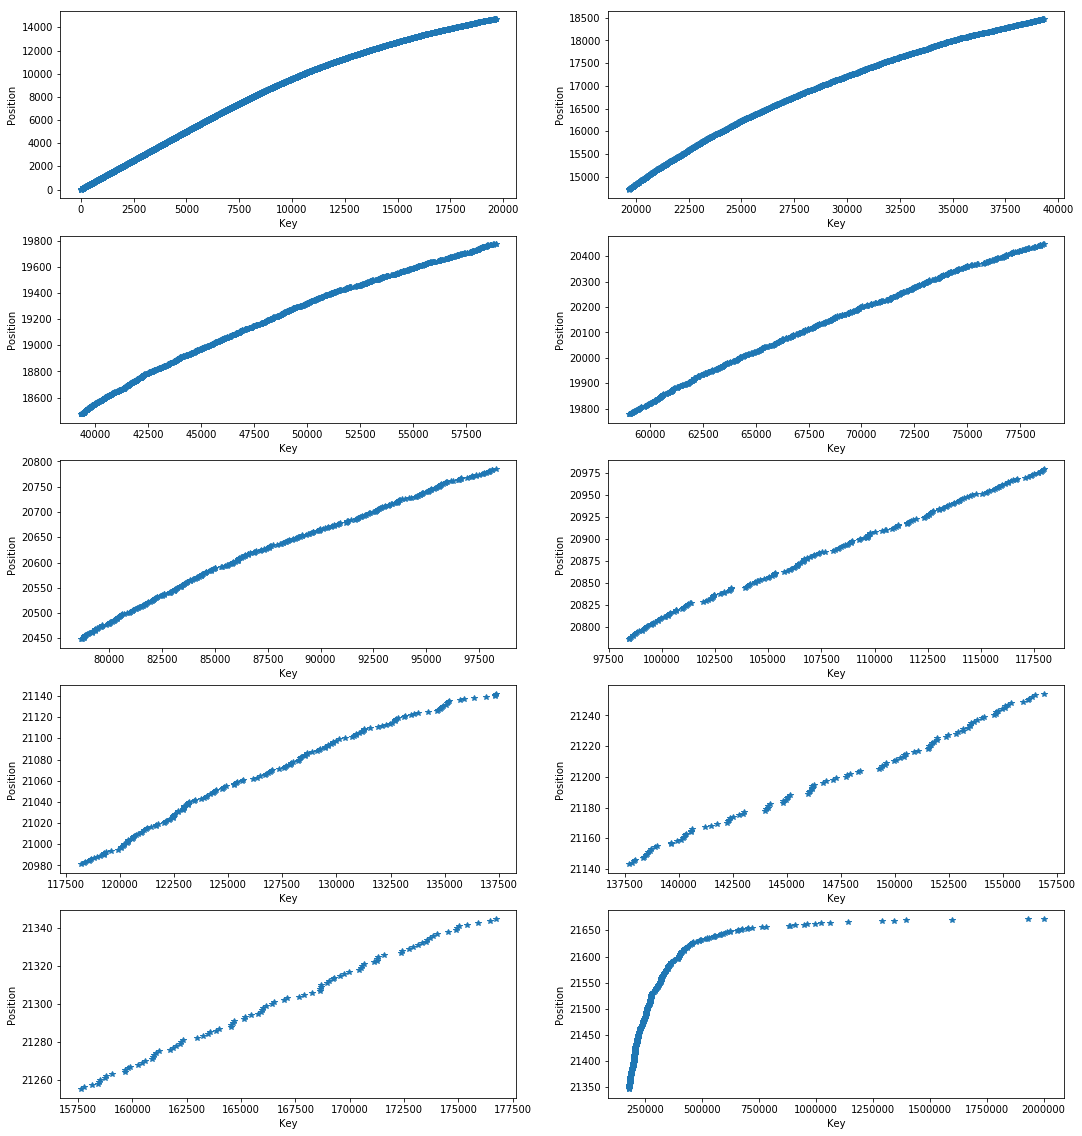

In [15]:
fig, axes = plt.subplots(n_second_stage_model / 2, 2, figsize=(18, n_second_stage_model * 2))
print(axes[0])
for idx in range(n_second_stage_model):
    axes[idx / 2, idx % 2].set_xlabel('Key')
    axes[idx / 2, idx % 2].set_ylabel('Position')
    axes[idx / 2, idx % 2].plot(x_bucket[idx], y_bucket[idx], linestyle='None', marker='*')
plt.show()

## Make predictions with the 2-stage RMI

In [16]:
pred_second = np.array([])
for i in range(n):
    pred_second = np.append(pred_second, (wts[sel_model[i]] * x[i] + bss[sel_model[i]]))
pred_second = pred_second.astype(np.int64)

## Evaluate the final results

min error = -14146
max error = 198784
min error = -697
max error = 1818


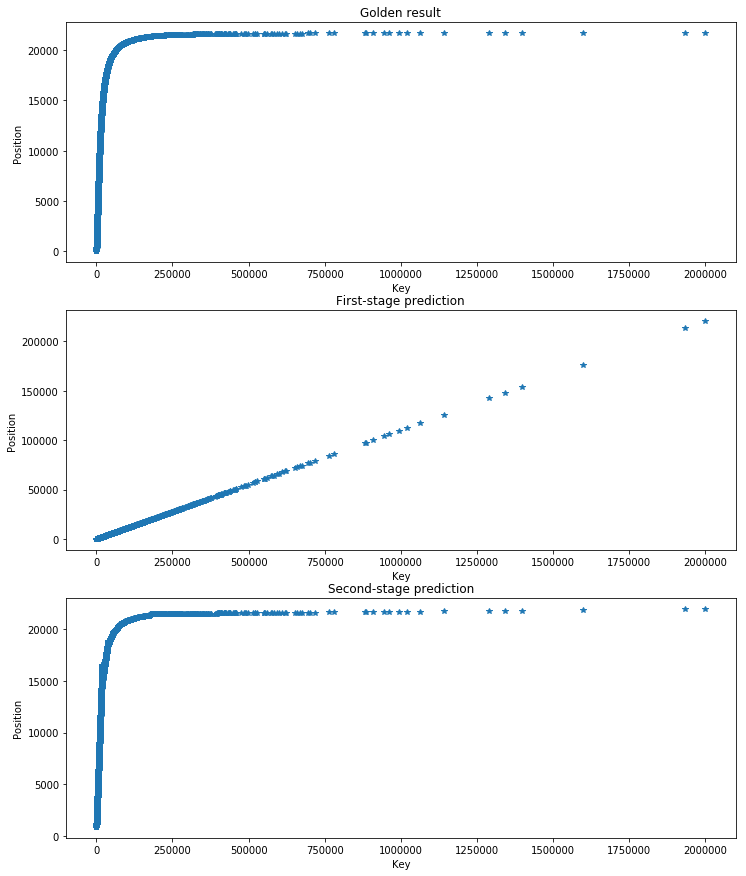

In [17]:
evalute_min_max_error(y, pred_first)
evalute_min_max_error(y, pred_second)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
axes[0].set_title('Golden result')
axes[0].set_xlabel('Key')
axes[0].set_ylabel('Position')
axes[0].plot(x, y, linestyle='None', marker='*')
axes[1].set_title('First-stage prediction')
axes[1].set_xlabel('Key')
axes[1].set_ylabel('Position')
axes[1].plot(x, pred_first, linestyle='None', marker='*')
axes[2].set_title('Second-stage prediction')
axes[2].set_xlabel('Key')
axes[2].set_ylabel('Position')
axes[2].plot(x, pred_second, linestyle='None', marker='*')
plt.show()